In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import warnings
import numpy as np
from lettuce.unit import UnitConversion
from lettuce.util import append_axes
from lettuce.boundary import EquilibriumBoundaryPU, BounceBackBoundary, HalfwayBounceBackBoundary, FullwayBounceBackBoundary, EquilibriumOutletP, AntiBounceBackOutlet, InterpolatedBounceBackBoundary
from lettuce.flows.cylinder2D import Cylinder2D
from lettuce.flows.obstacleCylinder import ObstacleCylinder

import torch
import time
import datetime
import os
import shutil
from pyevtk.hl import imageToVTK

In [2]:
### OUTPUT SETTINGS
output_data = True
output_vtk = False   # is overwritten with False if output_data=False (see below)
vtk_fps = 10

# IMPORTANT: set correct output_path, for example "/home/YourUserName/simulation_output"
output_path = "/mnt/ScratchHDD1/Max_Scratch/lbm_simulations"  # lokal HBRS
#output_path = "/home/max/Documents/lbm_simulations"  # lokal Bonn
#output_path = "/home/mbille3s/02_lbm_simulations"  # cluster HBRS

# name: if you want something specific in the dir-name
name = "cyl2D_test_VRAMrepoter"

# choose stencil: "D3Q9" dor 2D, "D3Q15", "D3Q19", "D3Q27" for 3D
stencil_choice = "D2Q9"
# choose collision operator: "bgk, "kbc", "reg"
collision_choice = "bgk"

In [3]:
### SIMULATION PARAMETERS (and estimation of timesteps needed to reach T_target)
re = 200   # Reynoldszahl
Ma = 0.05     # Machzahl
n_steps = 100#145492    # Schrittzahl
setup_diameter = 1  # D_PU = char_length_pu -> this defines the PU-Reference
flow_velocity = 1  # U_PU = char_velocity_pu -> this defines the PU-Reference velocity (u_max of inflow)

# relative starting point for drag-measurement (make sure periodic state is reached)
periodic_start = 0.9  # relative start of peak_finding for Cd_mean Measurement to cut of any transients

# GEOMETRY
gridpoints_per_diameter = 15 #1  # gp_per_D -> this defines the resolution ( D_LU = GPD)
domain_width_in_D = 5 #5  # D/Y = DpY = diameters per domain width in Y-direction -> this defines the domain-size and total number of Lattice-Nodes
domain_length_in_D = 2*domain_width_in_D  # D/X = domain length in X- / flow-direction

# RELATION [GPD to DpY] check
# if DpY is even, resulting GPD can't be odd for symmetrical cylinder and channel
# ...if DpY is even, GPD will be corrected to even GPD for symmetrical cylinder
# ...use odd DpY to use odd GPD
gpd_correction=False
if domain_width_in_D % 2 == 0 and gridpoints_per_diameter % 2 != 0:
    gpd_correction = True   # gpd_was_corrected-flag
    gpd_setup = gridpoints_per_diameter   # store old gpd for output
    gridpoints_per_diameter = int(gridpoints_per_diameter/2)*2   # make gpd even
    print("(!) domain_width_in_D is even, gridpoints_per_diameter will be "+str(gridpoints_per_diameter)+". Use odd domain_width_in_D to enable use of odd GPD!")

# SIMULATOR settings
u_init = 0    # initial velocity field: # 0: uniform u=0, # 1: uniform u=1 or parabolic, mean amplitude u_char_lu (similar to poiseuille-flow)
perturb_init = True   # perturb initial symmetry by small sine-wave in initial velocity field -> triggers Karman-vortex street for Re > 46
lateral_walls='periodic'  # type of top/bottom boundary: 'bounceback' = frictious wall, 'periodic' = periodic boundary, 'slip' = non-frictious wall
bc_type='fwbb'  # choose algorithm for bounceback-boundaries: fullway 'fwbb', halfway 'hwbb', linear interpolated 'ibb1'

# T_PU to n_steps estimation: (for example for Re=200 the periodic state is reached for T_PU > 140)
T_target=200
print("shape_LU:", gridpoints_per_diameter*domain_length_in_D, "x", gridpoints_per_diameter*domain_width_in_D)
print("T with", n_steps, "steps:", round(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity),2), "seconds")
print("n_steps to simulate 1 second:", round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")
print("n_steps to simulate",T_target,"seconds:",T_target*round(((gridpoints_per_diameter)/setup_diameter)*(flow_velocity/(Ma*1/np.sqrt(3))),2), "steps")

#exmpl: Re1000,steps25000,ny1000 braucht 43min
#Bonn: Re200, steps200000,gpd20?, 400x200 braucht 10min
#HBRS: Re200, steps100000, gpd20, 800x400 braucht 25min
#Bonn: Re200, steps175000, gpd35, 1330x665 braucht 62,3min

mlups_2060super = 20
mlups_2080ti = 30   # 40 for GPD30,DpY19,nsteps=150000 (steigend mit der Auflösung)

if output_vtk:
    print("generates approx.", int(vtk_fps*(n_steps * (setup_diameter/(gridpoints_per_diameter))*(Ma*1/np.sqrt(3)/flow_velocity)))+1, ".vti/.vtk-frames")

gridpoints = gridpoints_per_diameter**2*domain_length_in_D*domain_width_in_D
print("No. of gridpoints:", gridpoints)
print("estimated min. runtime on 2060super:", round(n_steps*gridpoints/(1e6*mlups_2060super),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2060super)/60,2),"minutes )")
print("estimated min. runtime on 2080ti:   ", round(n_steps*gridpoints/(1e6*mlups_2080ti),2), "seconds (", round(n_steps*gridpoints/(1e6*mlups_2080ti)/60,2),"minutes )")

shape_LU: 150 x 75
T with 100 steps: 0.19 seconds
n_steps to simulate 1 second: 519.62 steps
n_steps to simulate 200 seconds: 103924.0 steps
No. of gridpoints: 11250
estimated min. runtime on 2060super: 0.06 seconds ( 0.0 minutes )
estimated min. runtime on 2080ti:    0.04 seconds ( 0.0 minutes )


In [4]:
### (no user input) CREATE OUTPUT DIRECTORIES
if output_data:  # toggle output
    timestamp = datetime.datetime.now()
    timestamp = timestamp.strftime("%y%m%d")+"_"+timestamp.strftime("%H%M%S")

    dir_name = "/data_" + str(timestamp) + "_" + name
    os.makedirs(output_path+dir_name)
    
    if output_vtk:
        vtk_path = output_path+dir_name+"/vtk/out"
        print("vtk_path: " + vtk_path)
    print("dir_name: "+dir_name)
else:
    output_vtk = False

dir_name: /data_230830_133444_cyl2D_test_VRAMrepoter


In [5]:
### SIMULATOR SETUP

# lattice
lattice = lt.Lattice(lt.D2Q9, "cuda:0", dtype=torch.float64)
    # stencil, device, dtype

# flow = Cylinder2D(reynolds_number=re, mach_number=Ma,
#                    lattice=lattice,
#                    char_length_pu=setup_diameter,
#                    char_length_lu=gridpoints_per_diameter,
#                    char_velocity_pu=flow_velocity,
#                    y_lu=domain_width_in_D*gridpoints_per_diameter,
#                    x_lu=domain_length_in_D*gridpoints_per_diameter,
#                    lateral_walls=lateral_walls,
#                    bc_type=bc_type,
#                    perturb_init=perturb_init,
#                    u_init=u_init,
#                    radius=gridpoints_per_diameter/2
#                   )

flow = ObstacleCylinder(shape=(domain_length_in_D*gridpoints_per_diameter,
                               domain_width_in_D*gridpoints_per_diameter),
                        reynolds_number=re, mach_number=Ma,
                        lattice=lattice,
                        char_length_pu=setup_diameter,
                        char_length_lu=gridpoints_per_diameter,
                        char_velocity_pu=flow_velocity,
                        lateral_walls=lateral_walls,
                        bc_type=bc_type,
                        perturb_init=perturb_init,
                        u_init=u_init
                        )

# # define a Cylinder-Obstacle (in LU, 1-based!)
# radius_LU = 0.5 * gridpoints_per_diameter
# y_pos_LU = 0.5 * gridpoints_per_diameter * domain_width_in_D + 0.5
# x_pos_LU = y_pos_LU
#
# xyz = tuple(np.linspace(1,n,n) for n in flow.shape)  # Tupel aus Listen indizes (1-n (nicht 0-based!))
# xLU, yLU = np.meshgrid(*xyz, indexing='ij')  # meshgrid aus den x-, y- (und z-)Indizes
#
# condition = np.sqrt((xLU - x_pos_LU) ** 2 + (yLU - y_pos_LU) ** 2) < radius_LU
# flow.obstacle_mask[np.where(condition)] = 1

### simulation object (simulator)
tau = flow.units.relaxation_parameter_lu

# collision
if collision_choice == "reg":
    collision=lt.RegularizedCollision(lattice, tau)
elif collision_choice == "kbc":
    collision=lt.KBCCollision3D(lattice,tau)
else: # collision_choice = "bgk":
    collision=lt.BGKCollision(lattice, tau)

sim = lt.Simulation(flow, lattice,
                    collision,
                    # lt.BGKCollision(lattice, tau),
                    # lt.RegularizedCollision(lattice, tau),
                    # lt.KBCCollision2D(lattice,tau),
                    lt.StandardStreaming(lattice)
                   )
    # Flow, Lattice-Parameter, KollisionsOperator-Objekt(Parameter), Streaming-Objekt

### Reporter

# VTK Reporter -> Visualisierung
if output_vtk:
    VTKreport = lt.VTKReporter(lattice, flow, interval=int(flow.units.convert_time_to_lu(1/vtk_fps)), filename_base=vtk_path)
    sim.reporters.append(VTKreport)
    # export obstacle
    mask_dict = dict()
    mask_dict["mask"] = flow.obstacle_mask[...,None].astype(int)  # extension to pseudo-3D is needed for vtk-export to work
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_point",
        pointData=mask_dict,
    )
    imageToVTK(
        path=output_path+dir_name+"/vtk/obstacle_cell",
        cellData=mask_dict,
    )

# Observable reporter: drag coefficient
DragObservable = lt.DragCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)  # create Observable // ! area A=2*r is in PU
Dragreport = lt.ObservableReporter(DragObservable, out=None)  # create reporter
sim.reporters.append(Dragreport)  # append reporter to list
    
# Observable reporter: lift coefficient
LiftObservable = lt.LiftCoefficient(lattice,flow,sim._boundaries[-1],area=setup_diameter)
Liftreport = lt.ObservableReporter(LiftObservable, out=None)
sim.reporters.append(Liftreport)

# VRAM-repoter
VRAMreporter = lt.VRAMreporter(interval=10, filename_base=output_path+dir_name+"/vram_data/vram_summary")
sim.reporters.append(VRAMreporter)

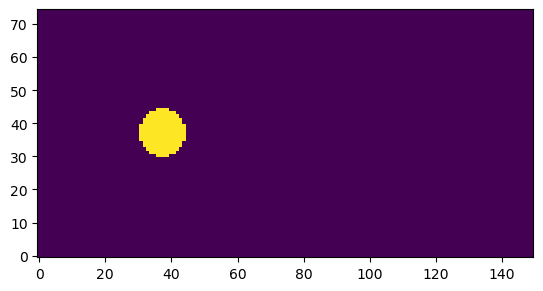

In [6]:
# show domain
plt.figure()
#plt.imshow(lattice.convert_to_numpy(torch.logical_xor(sim._boundaries[-1].mask, sim._boundaries[-1].f_mask[1])[190-20:190+20,190-20:190+20])[:,:].T, origin="lower")
plt.imshow(lattice.convert_to_numpy(torch.logical_xor(sim._boundaries[-1].mask, sim._boundaries[-1].f_mask[1]))[:,:].T, origin="lower")
ax = plt.gca()
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
#ax.set_xticks(np.arange(-.5, xmax, 1), minor=True)
#ax.set_yticks(np.arange(-.5, ymax, 1), minor=True)
#ax.grid(which="minor", color="w",linestyle='-', linewidth=2)

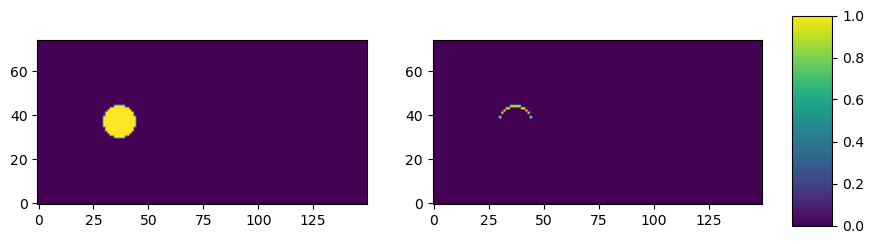

In [7]:
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[1,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[7,190-20:190+20,190-20:190+20]), origin="lower")
#plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[3].T), origin="lower")
print(sim._boundaries[-1])

fig, axes = plt.subplots(1,2, figsize=(10,3))
fig.subplots_adjust(right=0.85)
# im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].d[2,190-20:190+20,190-20:190+20].T), origin="lower")
# axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask[190-20:190+20,190-20:190+20].T), origin="lower")
im2 = plt.imshow(lattice.convert_to_numpy(sim._boundaries[-1].f_mask[4].T), origin="lower")
axes[0].imshow(lattice.convert_to_numpy(sim._boundaries[-1].mask.T), origin="lower")
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

In [8]:
### simple simulation

t_start=time.time()

mlups = sim.step(n_steps) #Simulation mit Schrittzahl n_steps

t_end=time.time()
runtime=t_end-t_start
print("MLUPS:", mlups)
print("PU-Time: ",flow.units.convert_time_to_pu(n_steps)," seconds")
print("number of steps:",n_steps)
print("runtime: ",runtime, "seconds (", round(runtime/60,2),"minutes )")

c_time = sim.time_avg["time_collision"]
s_time = sim.time_avg["time_streaming"]
b_time = sim.time_avg["time_boundary"]
r_time = sim.time_avg["time_reporter"]
sum_time = sim.time_avg["time_collision"] + sim.time_avg["time_streaming"] + sim.time_avg["time_boundary"] + sim.time_avg["time_reporter"]

print("collision avg. time:", sim.time_avg["time_collision"], "seconds (" + str(round(100 * c_time/sum_time, 2)) + " %)")
print("streaming avg. time:", sim.time_avg["time_streaming"], "seconds (" + str(round(100 * s_time/sum_time, 2)) + " %)")
print("boundary avg. time:", sim.time_avg["time_boundary"], "seconds (" + str(round(100 * b_time/sum_time, 2)) + " %)")
print("reporter avg. time:", sim.time_avg["time_reporter"], "seconds (" + str(round(100 * r_time/sum_time, 2)) + " %)")

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distribut

MLUPS: 1.078799083965265
PU-Time:  0.1924500897298753  seconds
number of steps: 100
runtime:  1.0430171489715576 seconds ( 0.02 minutes )
collision avg. time: 0.00032234187001449753 seconds (3.6 %)
streaming avg. time: 0.00025807709998844076 seconds (2.88 %)
boundary avg. time: 0.0006843501100775029 seconds (7.64 %)
reporter avg. time: 0.007696498249897559 seconds (85.89 %)


/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(
/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


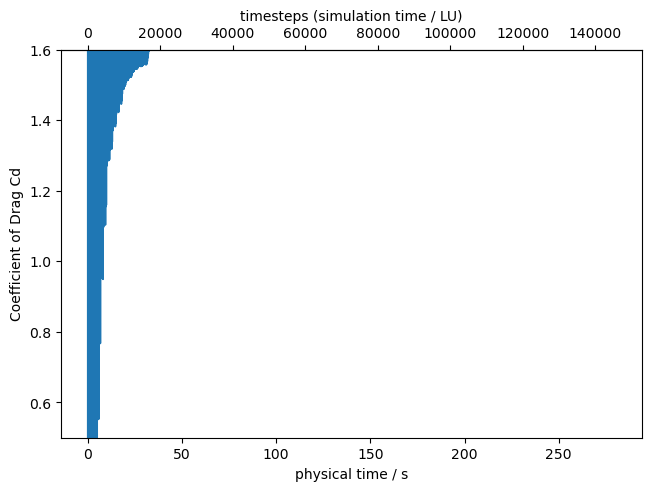

In [9]:
### plot DRAG COEFFICIENT

drag_coefficient = np.array(Dragreport.out)
#print('  stepLU        ', 'timePU        ', 'Cd')
#print(drag_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(drag_coefficient[:,1],drag_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])
#ax.set_ylim([1.54,1.545])
#ax.set_xlim([500,600])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/drag_coefficient.png")
    np.savetxt(output_path+dir_name+"/drag_coefficient.txt", drag_coefficient, header="stepLU  |  timePU  |  Cd  FROM str(timestamp)")
plt.show()

Cd, simple mean:      1.9071074003275206
Cd, peak_finder mean: 1.905273485686321
start time of 'mean'-ing: 251.99799649409331


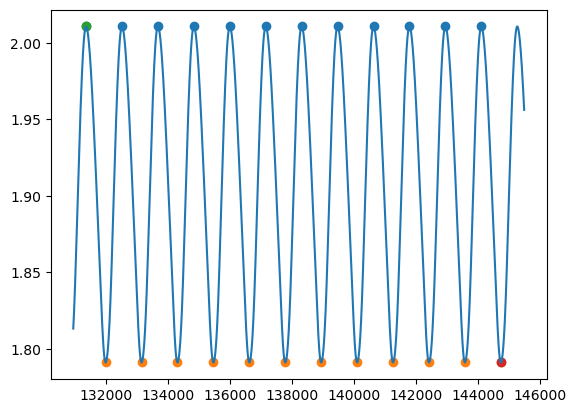

In [10]:
### calculate MEAN DRAG COEFFICIENT in periodic reagion:
try:
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]

    peaks_max = find_peaks(values, prominence=((values.max()-values.min())/2))
    peaks_min = find_peaks(-values, prominence=((values.max()-values.min())/2))
    # find peaks funktioniert hier nicht korrekt, wenn der Drag immernoch ansteigend ist...

    if peaks_min[0].shape[0] - peaks_max[0].shape[0] > 0:
        peak_number = peaks_max[0].shape[0]
    else:
        peak_number = peaks_min[0].shape[0]

    if peaks_min[0][0] < peaks_max[0][0]:
        first_peak = peaks_min[0][0]
        last_peak = peaks_max[0][peak_number-1]
    else:
        first_peak = peaks_max[0][0]
        last_peak = peaks_min[0][peak_number-1]

    drag_mean = values[first_peak:last_peak].mean()
    drag_mean_simple = values.mean()

    print("Cd, simple mean:     ",drag_mean_simple)
    print("Cd, peak_finder mean:",drag_mean)
    print("start time of 'mean'-ing:",drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1])
    ## plotting peaks from peak_finder:
    drag_stepsLU = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,0]
    peak_max_y = values[peaks_max[0]]
    peak_max_x = drag_stepsLU[peaks_max[0]]
    peak_min_y = values[peaks_min[0]]
    peak_min_x = drag_stepsLU[peaks_min[0]]

    plt.plot(drag_stepsLU, values)
    plt.scatter(peak_max_x[:peak_number],peak_max_y[:peak_number])
    plt.scatter(peak_min_x[:peak_number],peak_min_y[:peak_number])
    plt.scatter(drag_stepsLU[first_peak],values[first_peak])
    plt.scatter(drag_stepsLU[last_peak],values[last_peak])
    if output_data:
        plt.savefig(output_path+dir_name+"/drag_coefficient_peakfinder.png")
    peakfinder=True
except:
    print("peak-finding didn't work... probably no significant peaks visible (Re<46?), or periodic region not reached (T too small)")
    values = drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2]
    drag_mean_simple = values.mean()
    peakfinder=False
    print("Cd, simple mean:",drag_mean_simple)

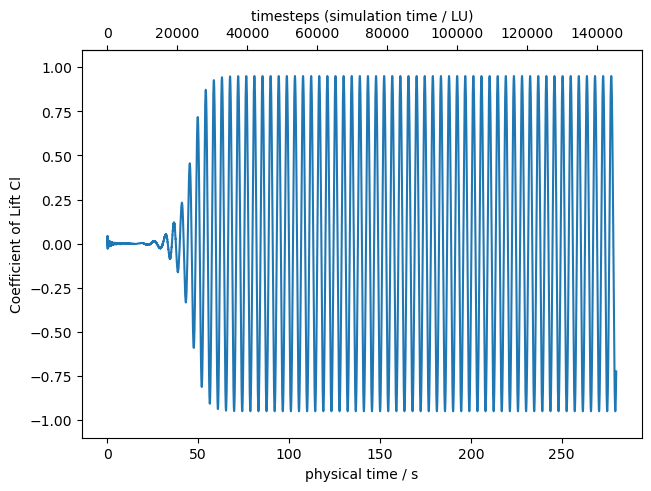

Cl_peaks: 
min -0.9500104304364798 
max 0.9500104288158188


In [11]:
### plot LIFT COEFFICIENT

lift_coefficient = np.array(Liftreport.out)
# print('  stepLU        ', 'timePU        ', 'Cl')
# print(lift_coefficient) # prints: stepLU, timePU, value

fig, ax = plt.subplots(constrained_layout=True)
ax.plot(lift_coefficient[:,1],lift_coefficient[:,2])
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Lift Cl")
ax.set_ylim([-1.1,1.1])
secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")
if output_data:
    plt.savefig(output_path+dir_name+"/lift_coefficient.png")
    np.savetxt(output_path+dir_name+"/lift_coefficient.txt", lift_coefficient, header="stepLU  |  timePU  |  Cl  FROM str(timestamp)")
plt.show()

Cl_min = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].min()
Cl_max = lift_coefficient[int(lift_coefficient[:,2].shape[0]*0.5):,2].max()

print("Cl_peaks: \nmin", Cl_min,"\nmax", Cl_max)

Frequency Peak: 0.22499886773282407 +- 0.0035714105989337157 Hz


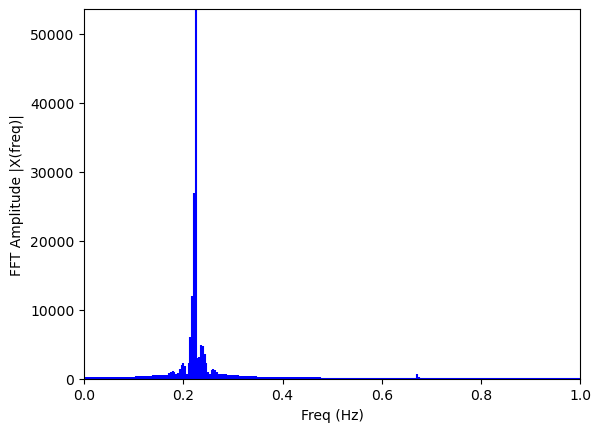

In [12]:
### prototyped fft for frequency detection and calculation of strouhal-number
# ! Drag_frequency is 2* Strouhal-Freq. Lift-freq. is Strouhal-Freq.

try:
    X = np.fft.fft(lift_coefficient[:,2])   # fft result (amplitudes)
    N = len(X)  # number of freqs
    n = np.arange(N)   # freq index
    T = N*flow.units.convert_time_to_pu(1)   # total time measured (T_PU)
    freq = n/T   # frequencies (x-axis of spectrum)

    plt.figure
    plt.stem(freq, np.abs(X), 'b', markerfmt=" ", basefmt="-b")   # plot spectrum |X|(f)
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FFT Amplitude |X(freq)|")
    plt.xlim(0,1)
    #print("max. Amplitude np.abx(X).max():", np.abs(X).max())   # for debugging
    plt.ylim(0,np.abs(X[:int(X.shape[0]*0.5)]).max())   # ylim, where highes peak is on left half of full spectrum

    if output_data:
        plt.savefig(output_path+dir_name+"/fft_Cl.png")

    freq_res = freq[1]-freq[0]   # frequency-resolution
    X_abs = np.abs(X[:int(X.shape[0]*0.4)])   # get |X| Amplitude for left half of full spectrum
    freq_peak = freq[np.argmax(X_abs)]    # find frequency with highest amplitude
    print("Frequency Peak:", freq_peak, "+-", freq_res, "Hz")
    # f = Strouhal for St=f*D/U and D=U=1 in PU
except:
    print("Strouhal-calculation failed, check simulation data")
    freq_res=0
    freq_peak=0

In [13]:
# save notebook to simulation_output
if output_data:
    try:
        shutil.copy(str(os.getcwd())+"/cylinder2D_development_v2.ipynb",output_path+dir_name+"/script.ipynb")
    except:
        print("script could not be saved")
else:
    print("output_data-toggle is FALSE")

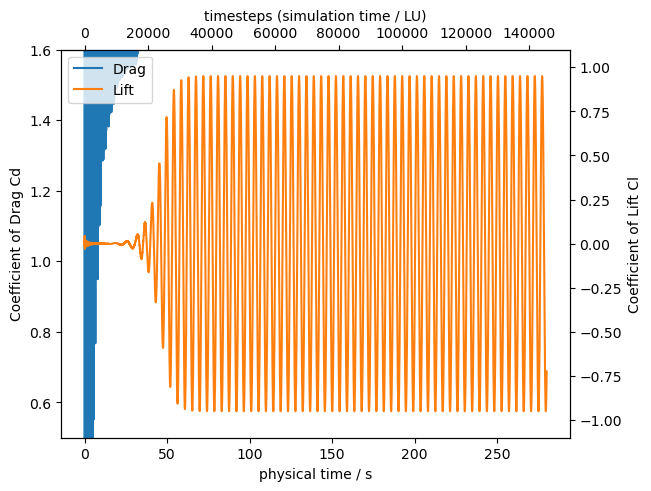

In [14]:
### plot Drag coefficient AND Lift Coefficient

#drag_coefficient = np.array(Dragreport.out)
#lift_coefficient = np.array(Liftreport.out)

fig, ax = plt.subplots(layout="constrained")
drag_ax = ax.plot(drag_coefficient[:,1],drag_coefficient[:,2], color="tab:blue", label="Drag")
ax.set_xlabel("physical time / s")
ax.set_ylabel("Coefficient of Drag Cd")
ax.set_ylim([0.5,1.6])

secax = ax.secondary_xaxis('top', functions=(flow.units.convert_time_to_lu, flow.units.convert_time_to_pu))
secax.set_xlabel("timesteps (simulation time / LU)")

ax2 = ax.twinx()
lift_ax = ax2.plot(lift_coefficient[:,1],lift_coefficient[:,2], color="tab:orange", label="Lift")
ax2.set_ylabel("Coefficient of Lift Cl")
ax2.set_ylim([-1.1,1.1])


fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

if output_data:
    plt.savefig(output_path+dir_name+"/dragAndLift_coefficient.png")

plt.show()

In [15]:
### plotte Dichte (mean, max, min) im Fluid-Bereich

# plt.figure
# plt.plot(np.arange(len(DragObservable.rho_max_list)),DragObservable.rho_max_list)
# plt.plot(np.arange(len(DragObservable.rho_min_list)),DragObservable.rho_min_list)
# plt.plot(np.arange(len(DragObservable.rho_mean_list)),DragObservable.rho_mean_list)
# plt.legend(labels=["rho_max", "rho_min", "rho_mean"])
# plt.ylim([0.99,1.01])
# if output_data:
#     plt.savefig(output_path+dir_name+"/density.png")

In [16]:
### Analysis of GPU memory usage (tensors)

if output_data:
### cudas own memory summary
    print(torch.cuda.memory_summary(device="cuda:0"))
    ### CUDA-VRAM-summary:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_memory_summary.txt", "a")
    output_file.write("DATA for "+timestamp+"\n\n")
    output_file.write(torch.cuda.memory_summary(device="cuda:0"))
    output_file.close()

### list present torch tensors:
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt", "a")
    total_bytes = 0
    import gc
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obj.data)):
                output_file.write("\n"+str(obj.size())+", "+str(obj.nelement()*obj.element_size()))
                total_bytes = total_bytes+obj.nelement()*obj.element_size()
        except:
            pass
    output_file.write("\n\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

### count occurence of tensors in list of tensors:
    from collections import Counter
    my_file = open(output_path+dir_name+"/"+timestamp + "_GPU_list_of_tensors.txt","r")
    data=my_file.read()
    my_file.close()
    data_into_list=data.split("\n")
    c = Counter(data_into_list)
    output_file = open(output_path+dir_name+"/"+timestamp + "_GPU_counted_tensors.txt", "a")
    for k,v in c.items():
        output_file.write("type,size,bytes: {}, number: {}\n".format(k,v) )
    output_file.write("\ntotal bytes for tensors:"+str(total_bytes))
    output_file.close()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1027 KB |    4545 KB |    3183 GB |    3183 GB |
|       from large pool |       0 KB |       0 KB |       0 GB |       0 GB |
|       from small pool |    1027 KB |    4545 KB |    3183 GB |    3183 GB |
|---------------------------------------------------------------------------|
| Active memory         |    1027 KB |    4545 KB |    3183 GB |    3183 GB |
|       from large pool |       0 KB |       0 KB |       0 GB |

/home/mbille/anaconda3/envs/lettuce/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [17]:
# output data
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters")
    output_file.write("\nRe = "+str(re))
    output_file.write("\nMa = "+str(Ma))
    output_file.write("\nn_steps = "+str(n_steps))
    output_file.write("\nsetup_diameter (D_PU) = "+str(setup_diameter))
    output_file.write("\nflow_velocity (U_PU) = "+str(flow_velocity))
    output_file.write("\nstencil = "+str(stencil_choice))
    output_file.write("\ncollision = " + str(collision_choice))
    output_file.write("\ngridpoints_per_diameter (gpd) = "+str(gridpoints_per_diameter))
    if gpd_correction:
        output_file.write("\ngpd was corrected from: "+str(gpd_setup)+" to "+str(gridpoints_per_diameter)+" because D/Y is even")
    output_file.write("\ndomain_width_in_D (D/Y) = "+str(domain_width_in_D))
    output_file.write("\ndomain_length_in_D (D/X) = "+str(domain_length_in_D))
    output_file.write("\n")
    output_file.write("\nu_init = "+str(u_init))
    output_file.write("\nperturb_init = "+str(perturb_init))
    output_file.write("\nlateral_walls = "+str(lateral_walls))
    output_file.write("\nbc_type = "+str(bc_type))
    output_file.write("\nvtk_fps = "+str(vtk_fps))
    output_file.write("\noutput_vtk = "+str(output_vtk))
    output_file.write("\n")
    #output_file.write("\nshape_LU: "+ str(flow.shape[0]) + " x " + str(flow.shape[1]))
    output_file.write("\nshape_LU: "+ str(flow.shape))
    output_file.write("\ntotal No. of gridpoints: "+ str(gridpoints))
    output_file.write("\n")
    output_file.write("output_dir: "+str(output_path+dir_name))
    output_file.write("\n")
    # output_file.write("\n###################\n\ncylinder:")
    # output_file.write("\nradius_LU = "+str(radius_LU))
    # output_file.write("\nx_pos_LU = "+str(x_pos_LU))
    # output_file.write("\ny_pos_LU = "+str(y_pos_LU))
    output_file.write("\ntau = "+str(tau))
    output_file.write("\n")
    output_file.write("\n###################\n\nSTATS:")
    output_file.write("\nT_PU = "+str(flow.units.convert_time_to_pu(n_steps))+" seconds")
    output_file.write("\nruntime = "+str(runtime)+ " seconds (="+str(runtime/60)+" minutes)")
    output_file.write("\nMLUPS = "+str(mlups))
    output_file.write("\n")
    output_file.write("\navg. Collision-Time [s] = " + str(c_time))
    output_file.write("\navg. Streaming-Time [s] = " + str(s_time))
    output_file.write("\navg. Boundary Condition-Time [s] = " + str(b_time))
    output_file.write("\navg. Reporter-Time [s] = " + str(r_time))
    output_file.write("\n")
    output_file.write("\n###################\n\nOBSERVABLES:")
    output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\nCd_mean, simple      = "+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\nCd_mean, peak_finder = "+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\nCd_min = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\nCd_max = "+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\nCoefficient of lift:")
    output_file.write("\nCl_min = "+str(Cl_min))
    output_file.write("\nCl_max = "+str(Cl_max))
    output_file.write("\n")
    output_file.write("\nStrouhal number:")
    output_file.write("\nf +- df = "+str(freq_peak)+" +- "+str(freq_res)+" Hz")
    output_file.write("\n")
    output_file.write("\n###################\n\nVRAM usage: see VRAM-summary for detailled information(!)")
    output_file.write("\ncurrent usage (MB) = " + str(torch.cuda.memory_allocated(device="cuda:0")/1024/1024))
    output_file.write("\npeak usage (MB) = " + str(torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024))
    output_file.write("\ncalculated MB by tensors = "+str(total_bytes/1024/1024))
    output_file.close()


In [18]:
if output_data:
    output_file = open(output_path+dir_name+"/"+timestamp + "_parameters_and_observables_copyable.txt", "a")
    output_file.write("DATA for "+timestamp)
    output_file.write("\n\n###################\n\nSIM-Parameters: Re, Ma, n_steps, setup_diameter, flow_velocity, stencil, collision, GPD, DpY, DpX, u_init, perturb_init, lateral_walls, bc_type, vtk_fps, output_vtk, shape_LU, gridpoints, output_dir, tau, T_PU, runtime, MLUPS, c_time, s_time, b_time, r_time, Cdmean, CdmeanPf, Cdmin, Cdmax, Clmin, Clmax, St, df, VRAM_current_MB, VRAM_max_MB")
    output_file.write("\n"+str(re))
    output_file.write("\n"+str(Ma))
    output_file.write("\n"+str(n_steps))
    output_file.write("\n"+str(setup_diameter))
    output_file.write("\n"+str(flow_velocity))
    output_file.write("\n"+str(gridpoints_per_diameter))
    output_file.write("\n"+str(domain_width_in_D))
    output_file.write("\n"+str(domain_length_in_D))
    output_file.write("\n"+str(u_init))
    output_file.write("\n"+str(perturb_init))
    output_file.write("\n"+str(lateral_walls))
    output_file.write("\n"+str(bc_type))
    output_file.write("\n"+str(vtk_fps))
    output_file.write("\n"+str(output_vtk))
    output_file.write("\n")
    output_file.write("\n"+str(flow.shape))
    output_file.write("\n"+ str(gridpoints))
    output_file.write("\n")
    output_file.write(""+str(output_path+dir_name))
    output_file.write("\n")
    # output_file.write("\n"+str(radius_LU))
    # output_file.write("\n"+str(x_pos_LU))
    # output_file.write("\n"+str(y_pos_LU))
    output_file.write("\n"+str(tau))
    output_file.write("\n")
    output_file.write("\n"+str(flow.units.convert_time_to_pu(n_steps)))
    output_file.write("\n"+str(runtime))
    output_file.write("\n"+str(mlups))
    output_file.write("\n")
    output_file.write("\n" +str(c_time))
    output_file.write("\n" +str(s_time))
    output_file.write("\n" +str(b_time))
    output_file.write("\n" +str(r_time))
    output_file.write("\n")
    #output_file.write("\n###################\n\nOBSERVABLES: CdmeanSimple, (Cdpeakfinder), Cdmin,Cdmax,Clmin,Clmax,St,df")
    #output_file.write("\nCoefficient of drag between "+str(round(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1),1],2))+" s and "+str(round(drag_coefficient[int(drag_coefficient.shape[0]-1),1],2))+" s:")
    output_file.write("\n"+str(drag_mean_simple))
    if peakfinder:
        output_file.write("\n"+str(drag_mean))
    else:
        output_file.write("\nnoPeaksFound")
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].min()))
    output_file.write("\n"+str(drag_coefficient[int(drag_coefficient.shape[0]*periodic_start-1):,2].max()))
    output_file.write("\n")
    output_file.write("\n"+str(Cl_min))
    output_file.write("\n"+str(Cl_max))
    output_file.write("\n")
    output_file.write("\n"+str(freq_peak))
    output_file.write("\n"+str(freq_res))
    output_file.write("\n")
    output_file.write("\n"+str(torch.cuda.memory_allocated(device="cuda:0")/1024/1024))
    output_file.write("\n"+str(torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024))
    output_file.write("\n"+str(total_bytes/1024/1024))
    output_file.close()

In [19]:
print("current VRAM (MB): ", torch.cuda.memory_allocated(device="cuda:0")/1024/1024)
print("max. VRAM (MB): ", torch.cuda.max_memory_allocated(device="cuda:0")/1024/1024)

current VRAM:  1.00341796875
max. VRAM:  4.43896484375
